# **Discretizing Causal Modeling WPS**

This scripts models the hybrid threat dynamics between attacker and defender using a causal Bayesian Network with causal interventions and later extending this approach to multi-agent causal influence diagram (MACID).

First we install and import relevant models. Then we define the causal Bayesian Network structure for modelling hybrid threat and create a Linear Program (LP) that solves the optimization problem for solving for the most optimal interventions. We then create the distributions that we sample from to generate data for running experiments. Finally, we generate figures for the experiments.

### **Import and Preprocess**

In [1]:
!pip install tables==3.5.1 &> /dev/nul
!pip install statsmodels &> /dev/nul
!pip install pickle-mixin &> /dev/nul
!pip install pyyaml==5.4.1 &> /dev/nul
!pip install pgmpy &> /dev/nul
!sudo apt install graphviz libgraphviz-dev graphviz-dev pkg-config &> /dev/nul
!pip install pygraphviz &> /dev/nul
!pip install pydot &> /dev/nul
!pip install pyparsing==1.5.7 &> /dev/nul
!pip install pulp &> /dev/nul

In [2]:
# importing pycid
try:
    import pycid
except ModuleNotFoundError:
    import sys

    !{sys.executable} -m pip install git+https://github.com/causalincentives/pycid # for the latest development version
    import pycid

  Cloning https://github.com/causalincentives/pycid to /tmp/pip-req-build-miqonspz
  Running command git clone --filter=blob:none --quiet https://github.com/causalincentives/pycid /tmp/pip-req-build-miqonspz
  Resolved https://github.com/causalincentives/pycid to commit 23666f9b6c8d1337a09eab267adbe45c9763756d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.6/631.6 kB 11.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.7 MB/s eta 0:00:00
  Created wheel for pycid: filename=pycid-0.8.2-py3-none-any.whl size=59996 sha256=85fd288bdab51069d6cef43ee1c95a5f7f2d959ed60ab25229ce1df339a9d4bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-7kf963hf/wheels/7f/96/33/303a5df8ac76cb00f2f635d5473e8ca57c1

In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import scipy
from scipy.stats import truncnorm, halfnorm
import sklearn
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
#import GML
import pickle
import statsmodels
import statsmodels.api
from IPython.display import Image, display
from google.colab import auth
from itertools import permutations
import pyparsing
from itertools import chain
from IPython.display import SVG
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import pgmpy
from pgmpy.sampling import BayesianModelSampling
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import MaximumLikelihoodEstimator
import pygraphviz as pgv
from pgmpy.inference import VariableElimination
from pgmpy.inference import CausalInference
from pycid.core.cpd import DecisionDomain, StochasticFunctionCPD
import pulp
from pulp import *

In [4]:
pd.__version__

'2.1.4'

In [5]:
# Change default plot size
plt.rcParams['figure.figsize'] = (10, 10)

# Set display settings
rc = {'lines.linewidth': 2, 'font.sans-serif': ['DejaVu Sans']}
sns.set_context('notebook', rc=rc, font_scale=1.25)
sns.set_style('whitegrid', rc=rc)

## **Model and Variable Introduction**

### **Construct the Network**

In [6]:
# Construct Digraph
edge_list=[('Deterrence', 'Attack'),('Deterrence', 'Pay-off'), ('Attack', 'Pay-off') ,('Deterrence', 'Deterrence_Costs'), ('Attack', 'Attack_Costs'),
           ('Pay-off', 'Attack_Pay-off'), ('Pay-off', 'Deterrence_Pay-off') , ('Attack_Costs', 'Attack_Pay-off'), ('Deterrence_Costs', 'Deterrence_Pay-off')]
sub_graph = nx.DiGraph(edge_list)

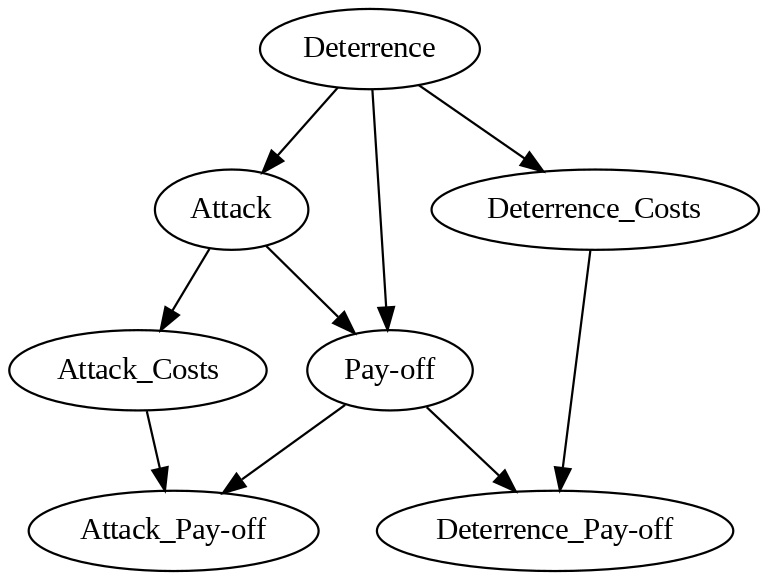

In [7]:
#draw using Pygraphiz
out_filename = "{}.png".format("G_sub")
agraph = nx.drawing.nx_agraph.to_agraph(sub_graph)
agraph.graph_attr.update(size="{},{}!".format((8, 6)[0], (8, 6)[0]))
agraph.draw(out_filename, format="png", prog="dot")
display(Image(filename="G_sub.png"))

### **CPDs**

*  Probability of **Deterrence**, which can be **D1 Intelligence Sharing**, **D2 Boosting Cyber Resilience**, **D3 Offensive Cyber Operation**, **D4 Market Restrictions**, **D5 Open Messaging**, **D6 No Deterrence Measure** denoted by **$D =\{D_{1}, D_{2}, D_{3}, D_{4}, D_{5}, D_{6}\}$**
*   Probabilities of **Attack** $A_i=\{\alpha_{i1}, \alpha_{i2} \}$ corresponding to either be **Attack** or **No-Attack** in reponse to deterrence measure $D_i$ are drawn from Beta distributions.
*   **Deterrence Cost**  are determined by the set **$\Gamma =\{\gamma_{1}\gamma_{2}, \gamma_{3}, \gamma_{4}, \gamma_{5}, \gamma_{6}\}$** and are all negative values.
*   **Attack Cost** are determined by the set **$ H =\{ \eta_{1}, \eta_{2} \}$** and are all negative values.
*   **Pay-off** are determined by the set **$\Theta=\{\theta_1,\theta_2,\theta_3\}$** where $\theta_1<\theta_2<\theta_3$. All values are positive and correspond to negative pay-off for the deterrer. Probabilities for pay-off are drawn from dirichlet distributions $\omega_{ij}$ corresponding to deterrence measure $D_i$ and attack respons $\alpha_{ij}$
*   **Deterrence Pay-off** $dp_i$ is then drawn from **$DP= \Gamma + \Theta$**  
*   **Attacker Pay-off** $ap_i$ is then drawn from **$DA= H - \Theta$**




## **Optimization Class Function**

In [8]:
class LP:
    """
    Class function to run the LP for deterrence and defender an spit out the results
    Attributes:
    -  Calculate Optimal Strategy for Deterrer
    -  Calculate Optimal Strategy for Attacker
    """

    def __init__(self, pay_off, pay_off_matrix, det_costs, att_costs, det_strat=None, att_strat=None):
        """
        Initiate data and logger and validates input
        :data (pd.Dataframe) : to be converted data
        """
        self.pay_off, self.pay_off_matrix, self.det_costs, self.att_costs = pay_off, pay_off_matrix, det_costs, att_costs
        self.attlen, self.detlen, self.pay_offlen = self.pay_off_matrix.shape
        self.det_strat= det_strat if det_strat is not None else np.eye(self.detlen)[0]
        self.att_strat= att_strat if att_strat is not None else np.eye(self.detlen)
        self.logger = logging.getLogger(__name__)
        assert np.array_equal(np.sum(self.att_strat, axis=0), np.ones(self.detlen)),\
            "Probabilities Attack Strategy should sum up to one"
        assert np.sum(self.det_strat) == 1,\
            "Probabilities Det Strategy should sum up to one"
        #assert np.array_equal(np.sum(self.pay_off_matrix, axis=2),np.ones([self.attlen, self.detlen])), \
        #    "Probabilities Pay-off should sum up to one"


    def deterrence_LP(self):
        """
        This solves all the LP steps, prints the problem status and returns the variable results
        """

        strat = {}
        for x in range(0, self.detlen):
            strat[x] = LpVariable(f"d[{x+1}]", lowBound=0, upBound=1, cat="Continuous")
        prob = LpProblem("Max pay-off", LpMaximize)
        # Creates the objective function
        prob.setObjective(sum(self.pay_off[y] * self.att_strat[t,x]*self.pay_off_matrix[t,x,y]*strat[x] for y in range(self.pay_offlen)
                                                                          for t in range(self.attlen)
                                                                          for x in range(self.detlen))
                         +sum(self.det_costs[x]*strat[x]                 for x in range(self.detlen)))
        prob += lpSum([strat[i] for i in range(self.detlen)]) <= 1
        prob += lpSum([strat[i] for i in range(self.detlen)]) >= 1
        # Solve ILP
        prob.solve()
        for variable in prob.variables():
          if variable.varValue > 0.1:
            optimal = variable
        return prob.variables(), optimal

    def attack_LP(self):
        """
        This solves all the LP steps, prints the problem status and returns the variable results
        """
        alp = {}
        for i in range(self.attlen):
            alp[i] = LpVariable(f"a[{i+1}]", lowBound=0, upBound=1, cat="Binary")
        prob = LpProblem("Min pay-off", LpMinimize)
        # Creates the objective function
        prob.setObjective(sum(self.pay_off[y]* alp[i]*self.pay_off_matrix[i,j,y]*self.det_strat[j] for y in range(self.pay_offlen)
                                                                          for i in range(self.attlen)
                                                                          for j in range(self.detlen))
                                            + sum(alp[i]*self.att_costs[i] for i in range(self.attlen)))
        prob += lpSum([alp[i] for i in range(self.attlen)]) <= 1
        prob += lpSum([alp[i]  for i in range(self.attlen)]) >= 1
        # Solve ILP
        prob.solve()
        prob.variables()
        for variable in prob.variables():
          if variable.varValue > 0.1:
            optimal = variable
        return prob.variables(), optimal

## **Creating Scenario's**

In [9]:
#Define the number of experiments
N = 1000

#Potential impacts theta: the hardest impacts
lower,upper,mu,sigma = 0,10000,3000,300 #theta_1
theta_1 = truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)

#mediocre impacts
lower,upper,mu,sigma = 0,10000,1000,50 #theta_2
theta_2 = truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
#negligible impacts
mu, sigma = 0, 5
theta_3 = halfnorm.rvs(loc=mu,scale=sigma,size=N)

In [10]:
# Deterrence Measures 1: Intelligence sharing
alpha11 = np.random.beta(5, 5, N) #Prob of attack after being deterrer does D1
lower,upper,mu,sigma = 0, 10000, 150, 50
costs_1 = truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N) #Deterring cost of D1 after being deterrer does D1
probs_1 = np.random.dirichlet((4, 8, 12), size=N) #Prob of pay-off after being deterrer does D1 and attacker A11

# Deterrence Measures 2: Boosting cyber resilience at the wider level
alpha21 = np.random.beta(4, 8, N)
lower,upper,mu,sigma = 0, 10000, 300, 50
costs_2 = truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
probs_2 = np.random.dirichlet((3, 5, 8), size=N)

# Deterrence Measures 3: Offensive cyber operation
alpha31 = np.random.beta(1, 1.2, N)
lower,upper,mu,sigma = 0, 10000, 250, 30
costs_3 = truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
probs_3 = np.random.dirichlet((1, 1, 1), size=N)

# Deterrence Measures 4: Market restrictions
alpha41 = np.random.beta(2, 8, N)
lower,upper,mu,sigma = 0, 10000, 400, 50
costs_4 = truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
probs_4 = np.random.dirichlet((2, 2, 15), size=N)

# Deterrence Measures 5: Open deterrence messaging through strategic operations
alpha51 = np.random.beta(0.4, 2, N)
lower,upper,mu,sigma = 0, 10000, 500, 250
costs_5 = truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
probs_5 = np.random.dirichlet((12, 6, 2), size=N)

# Deterrence Measures 6: no deterrence measure
alpha61 = alpha11
costs_6 = np.zeros(1000)
probs_6 = probs_5

In [11]:
theta = np.transpose([-theta_1, -theta_2, -theta_3])

#Pay-offs
pay_off = np.array([probs_1, probs_2, probs_3,
                    probs_4, probs_5, probs_6])
# Get the generated distribution in correct shape
pay_off = np.moveaxis(pay_off, -2, 0)
# Create additional pay_off for when there is no attack
pay_off2 = np.tile(np.array([0,0,1]).reshape(1,1,3),(N,6,1))
#Connect both pay_offs
pay_off = np.array([pay_off, pay_off2])

#Shape in correct shape for input model.
pay_off = np.moveaxis(pay_off, 1, 0)

costs = np.transpose([-costs_1, -costs_2, -costs_3, -costs_4, -costs_5, -costs_6])

alpha = np.array([[alpha11, alpha21, alpha31, alpha41, alpha51, alpha61],
                 [1-alpha11, 1-alpha21, 1-alpha31, 1-alpha41, 1-alpha51, 1-alpha61]])

#Shape in correct form for input for the model
alpha = np.moveaxis(alpha, -1, 0)

### **Plotting Disitrubtion Data**

In [49]:
# Change default plot size
plt.rcParams['figure.figsize'] = (9, 4)

# Set display settings
rc = {'lines.linewidth': 2, 'font.sans-serif': ['DejaVu Sans']}
sns.set_context('notebook', rc=rc, font_scale=1.25)
sns.set_style('whitegrid', rc=rc)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'D1 Intelligence Sharing'),
  Text(0, 1, 'D2 Boosting Cyber Resilience'),
  Text(0, 2, 'D3 Offensive Cyber Operation'),
  Text(0, 3, 'D4 Market Restrictions'),
  Text(0, 4, 'D5 Open Messaging'),
  Text(0, 5, 'D6 No Deterrence Measure')])

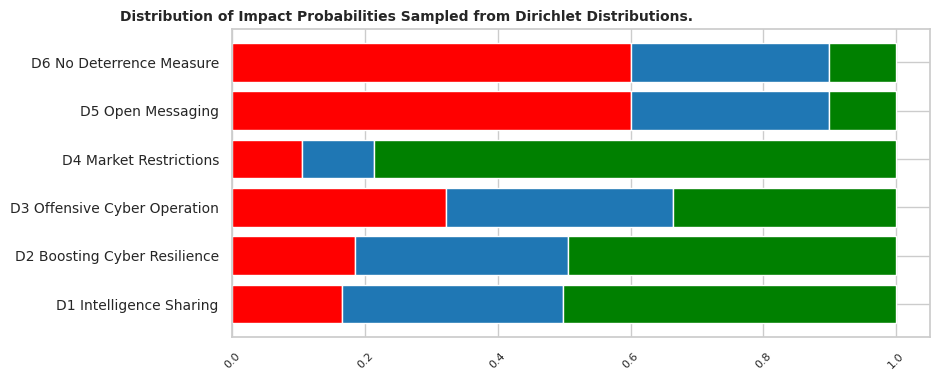

In [56]:
arrays = np.mean(probs_1, axis=0), np.mean(probs_2, axis=0), np.mean(probs_3, axis=0), np.mean(probs_4, axis=0), np.mean(probs_5, axis=0), np.mean(probs_6, axis=0)
s = np.stack(arrays).transpose()
plt.barh(['D1 Intelligence Sharing', 'D2 Boosting Cyber Resilience','D3 Offensive Cyber Operation','D4 Market Restrictions','D5 Open Messaging', 'D6 No Deterrence Measure'], s[0],  color='r')
plt.barh(['D1 Intelligence Sharing', 'D2 Boosting Cyber Resilience','D3 Offensive Cyber Operation','D4 Market Restrictions','D5 Open Messaging', 'D6 No Deterrence Measure'], s[1], left=s[0])
plt.barh(['D1 Intelligence Sharing', 'D2 Boosting Cyber Resilience','D3 Offensive Cyber Operation','D4 Market Restrictions','D5 Open Messaging', 'D6 No Deterrence Measure'], s[2], left=s[0]+s[1], color='g')
plt.title("Distribution of Impact Probabilities Sampled from Dirichlet Distributions.", fontweight="bold", fontsize = 10, x=0.25,y=1)
#ax.set_xlabel('Count', fontsize = 14, fontweight="bold")
plt.xticks(fontsize = 8, rotation=45)
plt.xticks(rotation=45)
plt.yticks(fontsize = 10)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'D1 Intelligence Sharing'),
  Text(0, 1, 'D2 Boosting Cyber Resilience'),
  Text(0, 2, 'D3 Offensive Cyber Operation'),
  Text(0, 3, 'D4 Market Restrictions'),
  Text(0, 4, 'D5 Open Messaging'),
  Text(0, 5, 'D6 No Deterrence Measure')])

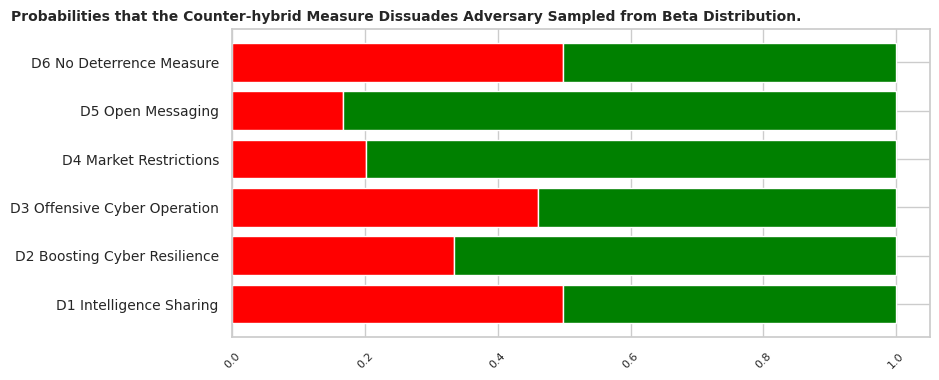

In [55]:
s = np.mean(alpha, axis=0)
plt.barh(['D1 Intelligence Sharing', 'D2 Boosting Cyber Resilience','D3 Offensive Cyber Operation','D4 Market Restrictions','D5 Open Messaging', 'D6 No Deterrence Measure'], s[0], color='r')
plt.barh(['D1 Intelligence Sharing', 'D2 Boosting Cyber Resilience','D3 Offensive Cyber Operation','D4 Market Restrictions','D5 Open Messaging', 'D6 No Deterrence Measure'], s[1], left=s[0], color='g')
plt.title("Probabilities that the Counter-hybrid Measure Dissuades Adversary Sampled from Beta Distribution.", fontweight="bold", fontsize = 10, x=0.25,y=1)
plt.xticks(fontsize = 8, rotation=45)
plt.xticks(rotation=45)
plt.yticks(fontsize = 10)

(array([  0.,  20.,  40.,  60.,  80., 100.]),
 [Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100')])

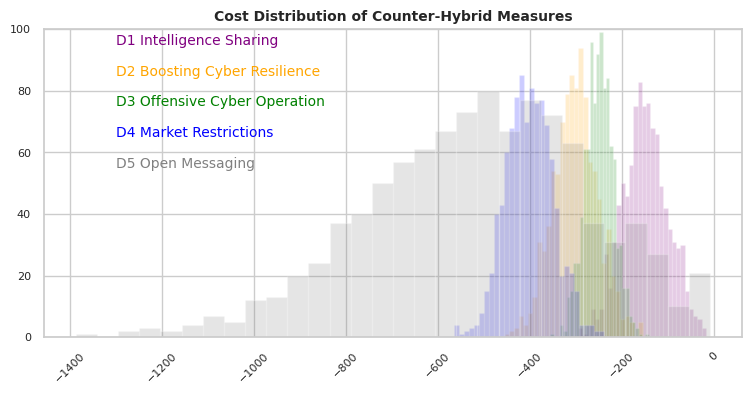

In [52]:
costs2 = costs.transpose()
plt.hist(costs2[0], bins=30, alpha=0.2, color='purple')
plt.hist(costs2[1], bins=30, alpha=0.2, color='orange')
plt.hist(costs2[2], bins=30, alpha=0.2, color='green')
plt.hist(costs2[3], bins=30, alpha=0.2, color='blue')
plt.hist(costs2[4], bins=30, alpha=0.2, color='grey')
plt.text(-1300, 95, r'D1 Intelligence Sharing', color='purple', fontsize = 10)
plt.text(-1300, 85, r'D2 Boosting Cyber Resilience', color='orange', fontsize = 10)
plt.text(-1300, 75, r'D3 Offensive Cyber Operation', color='green', fontsize = 10)
plt.text(-1300, 65, r'D4 Market Restrictions', color='blue', fontsize = 10)
plt.text(-1300, 55, r'D5 Open Messaging', color='grey', fontsize = 10)
plt.ylim(0, 100)
plt.title("Cost Distribution of Counter-Hybrid Measures", fontweight="bold", fontsize = 10)
plt.xticks(fontsize = 8, rotation=45)
plt.xticks(rotation=45)
plt.yticks(fontsize = 8)

(array([  0.,  20.,  40.,  60.,  80., 100.]),
 [Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100')])

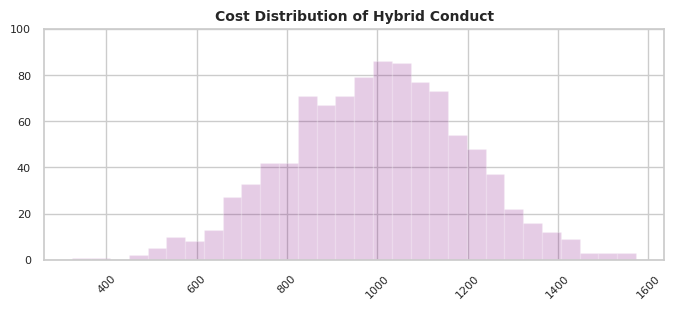

In [47]:
eta3 = eta.transpose()
plt.hist(eta3[0], bins=30, alpha=0.2, color='purple')
plt.ylim(0, 100)
plt.title("Cost Distribution of Hybrid Conduct", fontweight="bold", fontsize = 10)
plt.xticks(fontsize = 8, rotation=45)
plt.xticks(rotation=45)
plt.yticks(fontsize = 8)

### **Tests with various scenario's encoded as attack probabilities**

In [16]:
empty_list = []
strats = np.eye(6)
attlen, detlen, pay_offlen = 2,6,3
for i in range(1000):
  pay_off_, pay_off_matrix, det_costs, att_strat = theta[i], pay_off[i], costs[i], alpha[i]
  results = [sum(pay_off_[y] * att_strat[t,x]*pay_off_matrix[t,x,y]*strat[x] for y in range(pay_offlen)
                                                                          for t in range(attlen)
                                                                          for x in range(detlen))+sum(det_costs[x]*strat[x] for x in range(detlen)) for strat in strats]
  temp = sorted(results)
  res = [temp.index(i) for i in results]
  empty_list.append(res)

In [17]:
opt_solutions = pd.DataFrame(empty_list, columns=['D1 Intelligence Sharing', 'D2 Boosting Cyber Resilience','D3 Offensive Cyber Operation','D4 Market Restrictions','D5 Open Messaging', 'D6 No Deterrence Measure'])
opt_solutions = pd.melt(opt_solutions, var_name='Deterrence Measure')
mapping = {0:'Least Optimal', 1:'Fifth Most Optimal', 2:'Fourth Most Optimal', 3:'Third Most Optimal', 4:'Second Most Optimal', 5:'Most Optimal'}
opt_solutions['Ranks'] = opt_solutions['value'].map(mapping)
opt_solutions

,Deterrence Measure,value,Ranks
0,D1 Intelligence Sharing,3,Third Most Optimal
1,D1 Intelligence Sharing,3,Third Most Optimal
2,D1 Intelligence Sharing,5,Most Optimal
3,D1 Intelligence Sharing,4,Second Most Optimal
4,D1 Intelligence Sharing,4,Second Most Optimal
...,...,...,...
5995,D6 No Deterrence Measure,0,Least Optimal
5996,D6 No Deterrence Measure,0,Least Optimal
5997,D6 No Deterrence Measure,2,Fourth Most Optimal
5998,D6 No Deterrence Measure,0,Least Optimal


Text(0.5, 1.0, 'Countplot of the Rank of Counter-Cyber Measures')

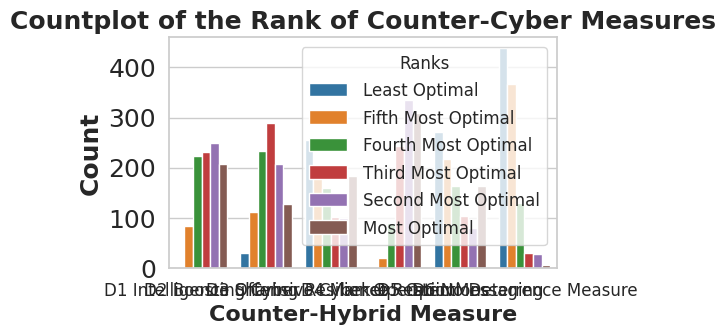

In [18]:
sns.countplot(x="Deterrence Measure", hue="Ranks", data=opt_solutions, hue_order=['Least Optimal','Fifth Most Optimal','Fourth Most Optimal','Third Most Optimal','Second Most Optimal','Most Optimal'])
# Change default plot size
plt.rcParams['figure.figsize'] = (30, 5)

# Set display settings
rc = {'lines.linewidth': 2, 'font.sans-serif': ['DejaVu Sans']}
sns.set_context('notebook', rc=rc, font_scale=1.25)
sns.set_style('whitegrid', rc=rc)
ax = plt.subplot()
ax.set_ylabel('Count', fontsize = 18, fontweight="bold")
plt.xticks(fontsize = 12, rotation=0)
plt.yticks(fontsize = 18)
ax.set_xlabel('Counter-Hybrid Measure', fontsize = 16, fontweight="bold")
plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='12')
plt.title('Countplot of the Rank of Counter-Cyber Measures', fontsize = 18, fontweight="bold")

In [34]:
plt.rcParams['figure.figsize'] = (25, 11)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

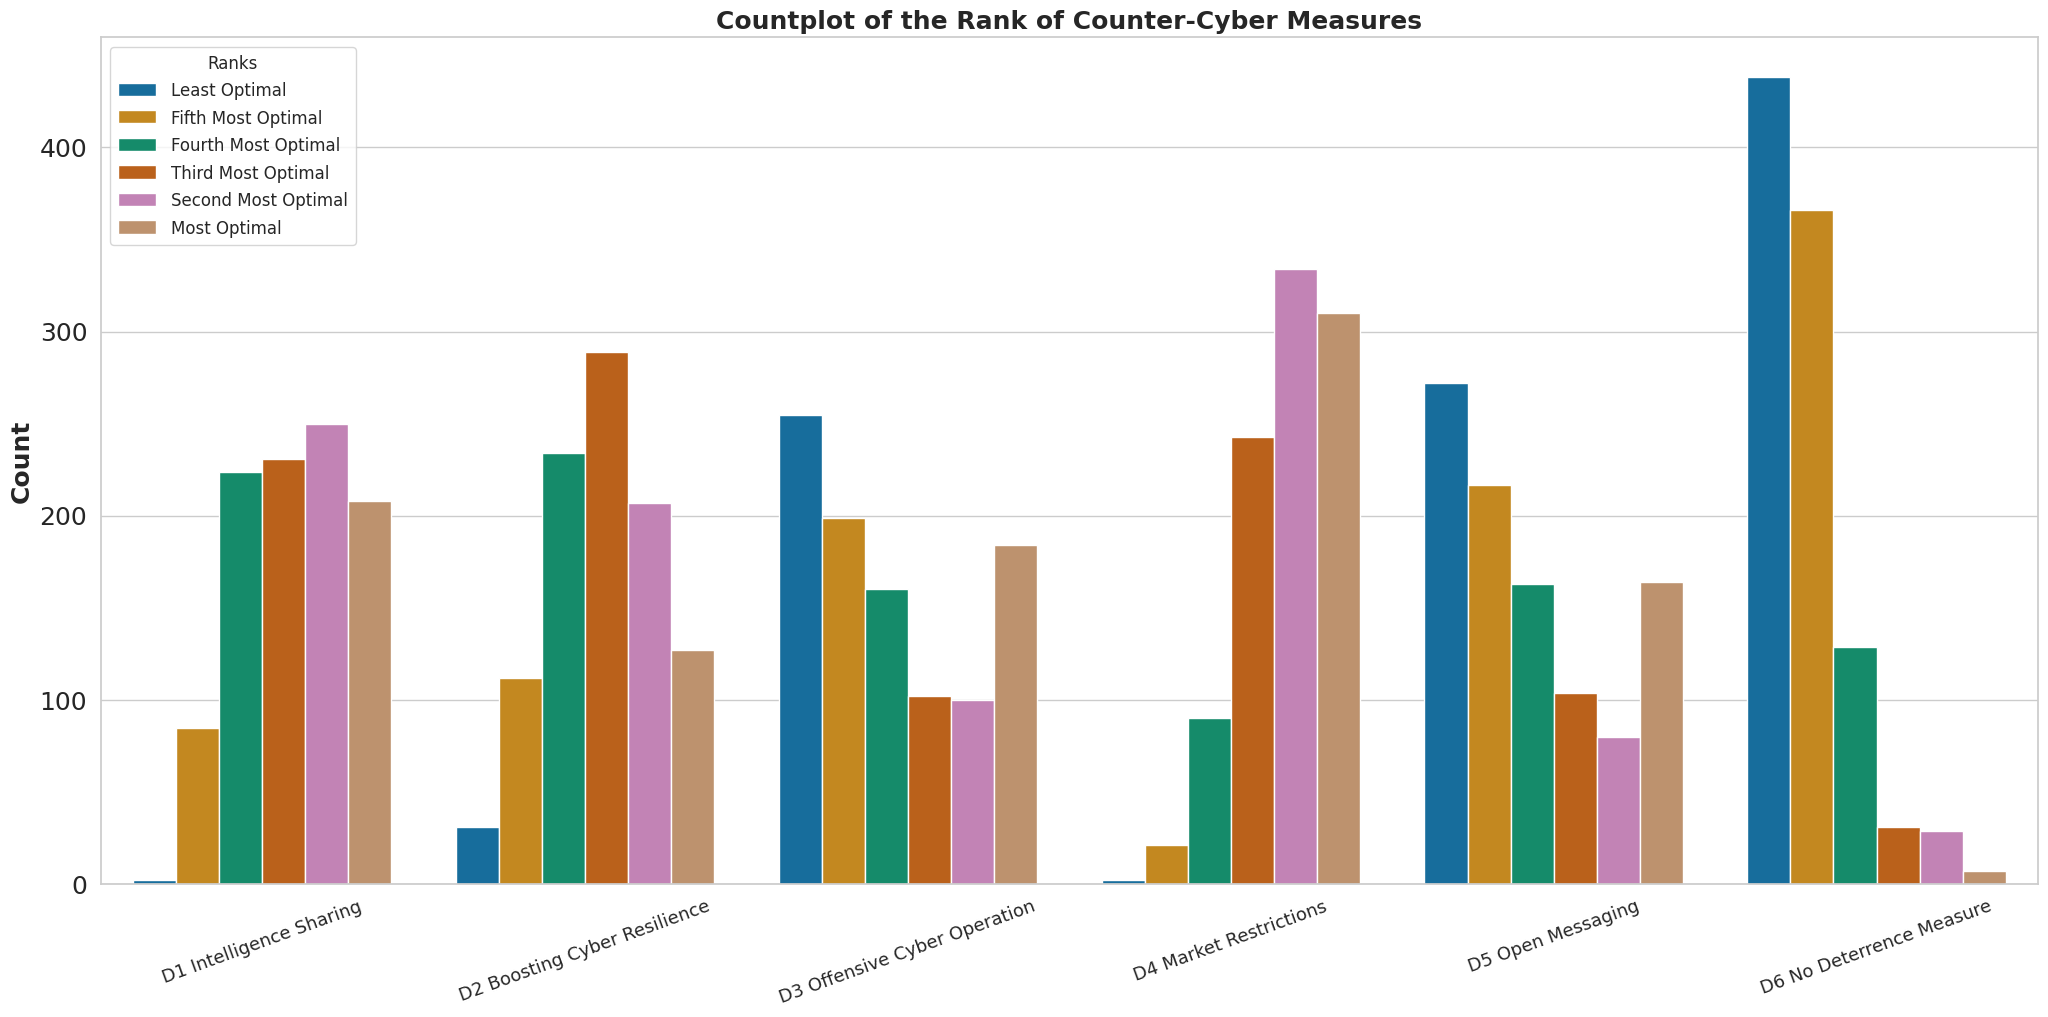

In [35]:
sns.countplot(x="Deterrence Measure", hue="Ranks", data=opt_solutions, palette='colorblind',
              hue_order=['Least Optimal','Fifth Most Optimal','Fourth Most Optimal','Third Most Optimal','Second Most Optimal','Most Optimal'])
# Change default plot size
plt.rcParams['figure.figsize'] = (25, 11)

# Set display settings
rc = {'lines.linewidth': 2, 'font.sans-serif': ['DejaVu Sans']}
sns.set_context('notebook', rc=rc, font_scale=1.25)
sns.set_style('whitegrid', rc=rc)
ax = plt.subplot()
ax.set_ylabel('Count', fontsize = 18, fontweight="bold")
plt.xticks(fontsize = 13, rotation=20)
plt.yticks(fontsize = 18)
ax.set_xlabel('', fontsize = 16, fontweight="bold")
plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='12')
plt.title('Countplot of the Rank of Counter-Cyber Measures', fontsize = 18, fontweight="bold")

fig = plt.gcf()
fig.savefig("BNhybrid.png", dpi=500)
from google.colab import files

# Assuming you've already saved the file as 'high_dpi_scatterplot.png'
files.download('BNhybrid.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

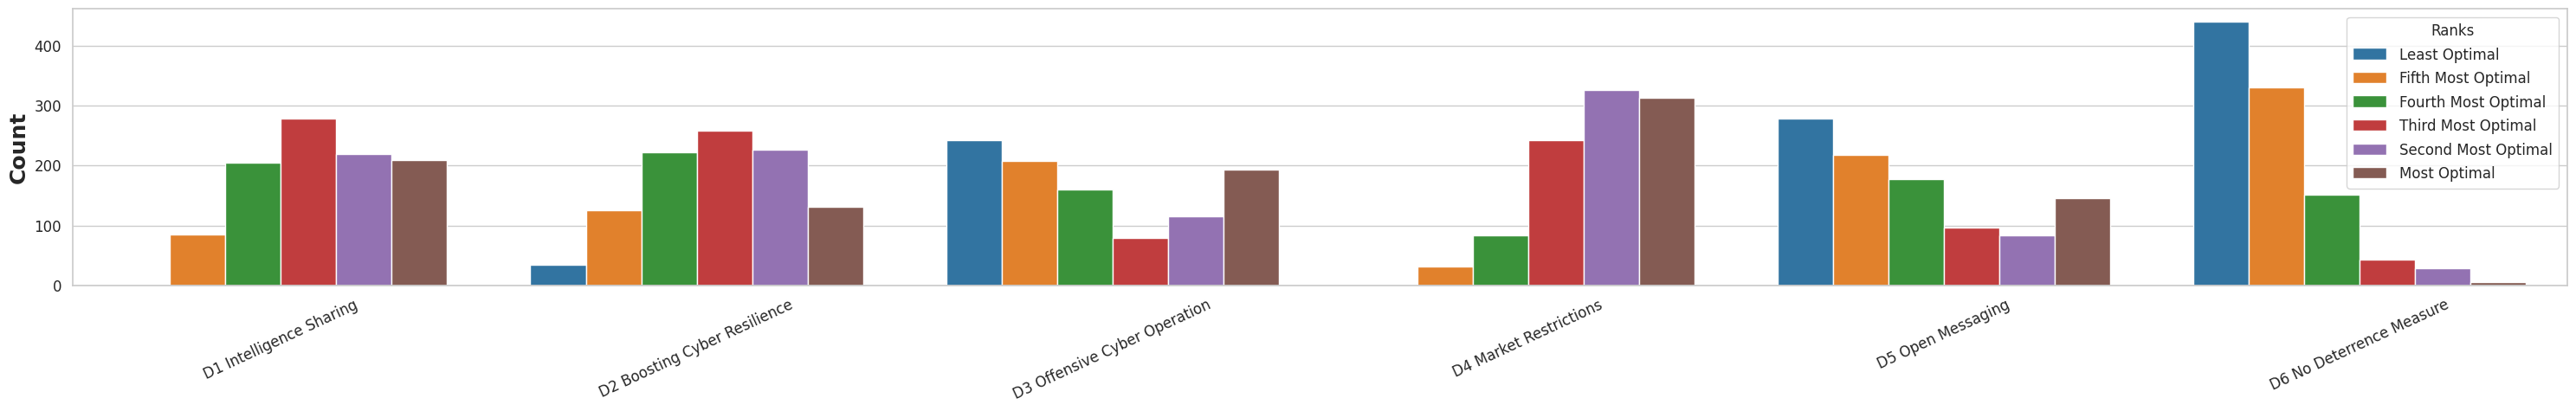

In [ ]:
sns.countplot(x="Deterrence Measure", hue="Ranks", data=opt_solutions, hue_order=['Least Optimal','Fifth Most Optimal','Fourth Most Optimal','Third Most Optimal','Second Most Optimal','Most Optimal'])
# Change default plot size
plt.rcParams['figure.figsize'] = (12, 7)

# Set display settings
rc = {'lines.linewidth': 3, 'font.sans-serif': ['DejaVu Sans']}
sns.set_context('notebook', rc=rc, font_scale=1.25)
sns.set_style('whitegrid', rc=rc)
ax = plt.subplot()
ax.set_ylabel('Count', fontsize = 18, fontweight="bold")
plt.xticks(fontsize = 12, rotation=25)
plt.yticks(fontsize = 12)
ax.set_xlabel('', fontsize = 16, fontweight="bold")
ax.figure.tight_layout()
plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='12')
#plt.title('Countplot of the Rank of Counter-Cyber Measures', fontsize = 18, fontweight="bold")

fig = plt.gcf()
fig.savefig("Hybrid2count.png", dpi=400)
from google.colab import files

# # Assuming you've already saved the file as 'high_dpi_scatterplot.png'
files.download('Hybrid2count.png')

In [ ]:


# Change default plot size
plt.rcParams['figure.figsize'] = (7, 23.5)

# Set display settings
rc = {'lines.linewidth': 2, 'font.sans-serif': ['DejaVu Sans']}
sns.set_context('notebook', rc=rc, font_scale=1.25)
sns.set_style('whitegrid', rc=rc)

Text(0.5, 1.0, 'Countplot of the Rank of Counter-Cyber Measures')

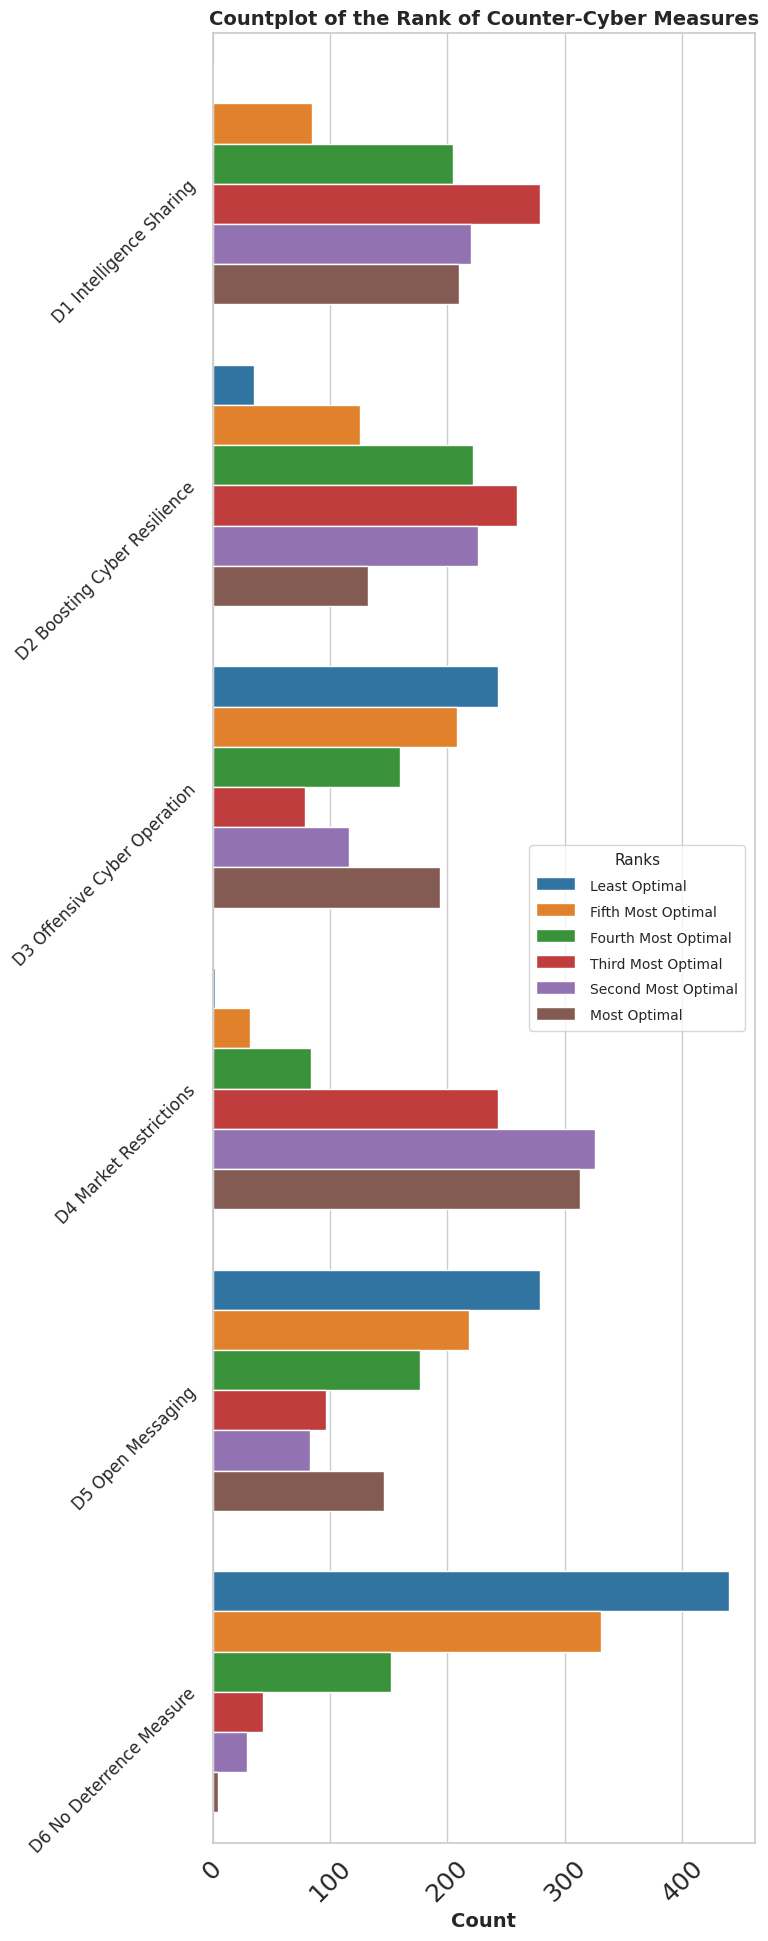

In [ ]:
sns.countplot(y="Deterrence Measure", hue="Ranks", data=opt_solutions, hue_order=['Least Optimal','Fifth Most Optimal','Fourth Most Optimal','Third Most Optimal','Second Most Optimal','Most Optimal'])

ax = plt.subplot()
ax.set_ylabel('', fontsize = '15', fontweight="bold")
ax.set_xlabel('Count', fontsize = 14, fontweight="bold")
plt.xticks(fontsize = 18, rotation=45)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.yticks(fontsize = 12)
plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='11')
plt.title('Countplot of the Rank of Counter-Cyber Measures', fontsize = 14, fontweight="bold")

In [ ]:
opt_solutions

,Deterrence Measure,value,Ranks
0,D1 Intelligence Sharing,4,Second Most Optimal
1,D1 Intelligence Sharing,5,Most Optimal
2,D1 Intelligence Sharing,3,Third Most Optimal
3,D1 Intelligence Sharing,5,Most Optimal
4,D1 Intelligence Sharing,1,Fifth Most Optimal
...,...,...,...
5995,D6 No Deterrence Measure,0,Least Optimal
5996,D6 No Deterrence Measure,0,Least Optimal
5997,D6 No Deterrence Measure,3,Third Most Optimal
5998,D6 No Deterrence Measure,1,Fifth Most Optimal


In [ ]:
LP_instance = LP(pay_off=theta[0], pay_off_matrix=pay_off[0], det_costs=costs[0], att_costs=None, det_strat=None,
                       att_strat=alpha[0])
variables, optimal = LP_instance.deterrence_LP()

/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [ ]:
optimal_solutions = []
for i in range(1000):
  LP_instance = LP(pay_off=theta[i], pay_off_matrix=pay_off[i], det_costs=costs[i], att_costs=None, det_strat=None, att_strat=alpha[i])
  variables, optimal = LP_instance.deterrence_LP()
  optimal_solutions.append(str(optimal))

print(optimal_solutions)

['d_4_', 'd_1_', 'd_2_', 'd_1_', 'd_2_', 'd_4_', 'd_5_', 'd_1_', 'd_4_', 'd_3_', 'd_1_', 'd_2_', 'd_3_', 'd_5_', 'd_5_', 'd_4_', 'd_3_', 'd_4_', 'd_3_', 'd_4_', 'd_5_', 'd_1_', 'd_3_', 'd_4_', 'd_1_', 'd_5_', 'd_1_', 'd_2_', 'd_4_', 'd_4_', 'd_3_', 'd_3_', 'd_4_', 'd_3_', 'd_2_', 'd_4_', 'd_4_', 'd_3_', 'd_4_', 'd_5_', 'd_3_', 'd_4_', 'd_1_', 'd_4_', 'd_1_', 'd_4_', 'd_5_', 'd_5_', 'd_4_', 'd_4_', 'd_5_', 'd_1_', 'd_5_', 'd_4_', 'd_1_', 'd_4_', 'd_1_', 'd_3_', 'd_4_', 'd_4_', 'd_5_', 'd_4_', 'd_1_', 'd_1_', 'd_4_', 'd_2_', 'd_5_', 'd_1_', 'd_1_', 'd_4_', 'd_4_', 'd_4_', 'd_1_', 'd_1_', 'd_5_', 'd_5_', 'd_1_', 'd_1_', 'd_3_', 'd_3_', 'd_5_', 'd_4_', 'd_1_', 'd_4_', 'd_4_', 'd_4_', 'd_4_', 'd_4_', 'd_3_', 'd_4_', 'd_4_', 'd_2_', 'd_5_', 'd_1_', 'd_3_', 'd_4_', 'd_1_', 'd_2_', 'd_1_', 'd_5_', 'd_3_', 'd_1_', 'd_4_', 'd_4_', 'd_4_', 'd_1_', 'd_4_', 'd_1_', 'd_5_', 'd_1_', 'd_2_', 'd_3_', 'd_4_', 'd_3_', 'd_4_', 'd_4_', 'd_1_', 'd_3_', 'd_3_', 'd_1_', 'd_3_', 'd_5_', 'd_1_', 'd_4_', 'd_3_',

### **Variables for the MACID**

In [38]:
#Multiple experiments
N = 1000

#Costs for the attacker
lower,upper,mu,sigma = 0,5000,1000,200 #eta
eta_1 = truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
eta_2 = np.zeros(N)
eta = np.array([eta_1,eta_2]).T

#Potential impacts theta
lower,upper,mu,sigma = 0,10000,3000,300 #theta_1
theta_1 = truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
lower,upper,mu,sigma = 0,10000,1000,50 #theta_2
theta_2 = truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
mu, sigma = 0, 5
theta_3 = halfnorm.rvs(loc=mu,scale=sigma,size=N)

In [ ]:
# Deterrence Measures 1: Intelligence sharing
alpha11 = np.random.beta(5, 5, N)
lower,upper,mu,sigma = 0, 10000, 150, 50
costs_1 = truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
probs_1 = np.random.dirichlet((4, 8, 12), size=N)

# Deterrence Measures 2: Boosting cyber resilience at the wider level
alpha21 = np.random.beta(4, 8, N)
lower,upper,mu,sigma = 0, 10000, 300, 50
costs_2 = truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
probs_2 = np.random.dirichlet((3, 5, 8), size=N)

# Deterrence Measures 3: Offensive cyber operation
alpha31 = np.random.beta(1, 1.2, N)
lower,upper,mu,sigma = 0, 10000, 250, 30
costs_3 = truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
probs_3 = np.random.dirichlet((1, 1, 1), size=N)

# Deterrence Measures 4: Market restrictions
alpha41 = np.random.beta(2, 8, N)
lower,upper,mu,sigma = 0, 10000, 400, 50
costs_4 = truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
probs_4 = np.random.dirichlet((2, 2, 15), size=N)

# Deterrence Measures 5: Open deterrence messaging through strategic operations
alpha51 = np.random.beta(0.4, 2, N)
lower,upper,mu,sigma = 0, 10000, 500, 250
costs_5 = truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
probs_5 = np.random.dirichlet((12, 6, 2), size=N)

# Deterrence Measures 6: no deterrence measure
alpha61 = alpha11
costs_6 = np.zeros(1000)
probs_6 = probs_5

In [ ]:
theta = np.transpose([-theta_1, -theta_2, -theta_3])

#Pay-offs
pay_off = np.array([probs_1, probs_2, probs_3,
                    probs_4, probs_5, probs_6])


# Get the generated distribution in correct shape
pay_off = np.moveaxis(pay_off, -2, 0)
# Create additional pay_off for when there is no attack
pay_off2 = np.tile(np.array([0,0,1]).reshape(1,1,3),(N,6,1))
#Connect both pay_offs
pay_off = np.array([pay_off, pay_off2])

#Shape in correct shape for input model.
pay_off = np.moveaxis(pay_off, 1, 0)

costs = np.transpose([-costs_1, -costs_2, -costs_3, -costs_4, -costs_5, -costs_6])

alpha = np.array([[alpha11, alpha21, alpha31, alpha41, alpha51, alpha61],
                 [1-alpha11, 1-alpha21, 1-alpha31, 1-alpha41, 1-alpha51, 1-alpha61]])

#Shape in correct form for input for the model
alpha = np.moveaxis(alpha, -1, 0)

## **Define the MACID and MACIM**

In [ ]:
domain_ch = ["D1", "D2", "D3", "D4", "D5", "D6"]
domain_ha = ["Attack", "No attack"]
domain_pay = ["Substantial", "Marginal", "Negligible"]


In [ ]:
import numpy as np
import pycid

# Create a MACID with the decision nodes, utility nodes, and agent assignments
macid = pycid.MACID(
    [("CH", "PAY"), ("CH", "HA"), ("CH", "U1"), ("PAY", "U1"), ("HA", "PAY"), ("PAY", "U2"), ("HA", "U2")],
    agent_decisions={1: ["CH"], 2: ["HA"]},
    agent_utilities={1: ["U1"], 2: ["U2"]},
)

#Define the domains
domain_ch = ["D1", "D2", "D3", "D4", "D5", "D6"]
domain_ha = ["Attack", "No attack"]
domain_pay = ["Substantial", "Marginal", "Negligible"]

#Define the pay-offs
agent1_payoff = {
    (decision, outcome): costs[0][i] + theta[0][j]
    for i, decision in enumerate(domain_ch)
    for j, outcome in enumerate(domain_pay)}

agent2_payoff = {
    (decision, outcome): -eta[0][i] - theta[0][j]
    for i, decision in enumerate(domain_ha)
    for j, outcome in enumerate(domain_pay)}

# Add the CPDs to the MACID
macid.add_cpds(
    CH=domain_ch,
    HA=domain_ha,
    PAY = TabularCPD(
        "PAY",
        3,
        np.split(pay_off[0].T.flatten(),3),
        evidence=["CH", "HA"],
        evidence_card=[6, 2],
        state_names={'PAY': domain_pay}
    ),
    U1=lambda CH, PAY: agent1_payoff[(CH, PAY)],
    U2=lambda HA, PAY: agent2_payoff[(HA, PAY)]
)

# Display or further work with the macid
print(macid)

MACID with 5 nodes and 7 edges


<ipython-input-26-72d765271eda>:31: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  PAY = TabularCPD(


In [ ]:
macid.get_spe()

[[StochasticFunctionCPD<HA> 
  {'CH': 'D1'}  ->  Attack
  {'CH': 'D2'}  ->  Attack
  {'CH': 'D3'}  ->  Attack
  {'CH': 'D4'}  ->  Attack
  {'CH': 'D5'}  ->  Attack
  {'CH': 'D6'}  ->  Attack,
  StochasticFunctionCPD<CH> 
  {}  ->  D1]]

In [ ]:
results=[]
for k in range(0,1000):
  #Define the pay-offs
  agent1_payoff = {
      (decision, outcome): costs[k][i] + theta[k][j]
      for i, decision in enumerate(domain_ch)
      for j, outcome in enumerate(domain_pay)}

  agent2_payoff = {
      (decision, outcome): -eta[k][i] - theta[k][j]
      for i, decision in enumerate(domain_ha)
      for j, outcome in enumerate(domain_pay)}

  # Add the CPDs to the MACID
  macid.add_cpds(
      CH=domain_ch,
      HA=domain_ha,
      PAY = TabularCPD(
          "PAY",
          3,
          np.split(pay_off[k].T.flatten(),3),
          evidence=["CH", "HA"],
          evidence_card=[6, 2],
          state_names={'PAY': domain_pay}
      ),
      U1=lambda CH, PAY: agent1_payoff[(CH, PAY)],
      U2=lambda HA, PAY: agent2_payoff[(HA, PAY)]
  )
  results.append(macid.get_spe(solver="enumpure")[0])


<ipython-input-28-ab21c0c305df>:18: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  PAY = TabularCPD(


In [ ]:
all_data=[]
for result in results:
    # Step 2: Use regex to extract CH values and their corresponding results (Attack/No attack) for each string
    pattern = r"\{'CH': 'D(\d+)'\}  ->  (Attack|No attack)"
    matches = re.findall(pattern, str(result))

    eq_choice_pattern = r"\{\}  ->  (D\d+)"
    eq_choice = re.findall(eq_choice_pattern, str(result))[0]

    eq_choice_pattern2 = r"\{'CH': '" + eq_choice + r"'\}  ->  (Attack|No attack)"
    eq_choice2 = re.findall(eq_choice_pattern2, str(result))[0]

    # Step 3: Convert to a list of dictionaries and append to all_data
    for ch, result in matches:
        all_data.append({'CH': f'D{ch}', 'Result': result, 'Deterrence_Equilibrium': eq_choice, 'Adversary Equilibrium': eq_choice2})

# Step 4: Convert all collected data into a single DataFrame
df = pd.DataFrame(all_data)

# The mapping dictionary for CH values to Deterrence Measures
ch_mapping = {
    'D1': 'D1 Intelligence Sharing',
    'D2': 'D2 Boosting Cyber Resilience',
    'D3': 'D3 Offensive Cyber Operation',
    'D4': 'D4 Market Restrictions',
    'D5': 'D5 Open Messaging',
    'D6': 'D6 No Deterrence Measure'
}

# Map the CH values to the full Deterrence Measure names
df['Deterrence Measure'] = df['CH'].map(ch_mapping)
df['Deterrence Equilibrium'] = df['Deterrence_Equilibrium'].map(ch_mapping)
df.rename(columns={'Result':'Adversary Action'}, inplace=True)
# Drop the old 'CH' column and rename 'Result' column
df = df.drop(columns=['CH','Deterrence_Equilibrium'])
df['Equilibria'] = list(zip(df['Deterrence Equilibrium'], df['Adversary Equilibrium']))
df['Strategy Profile Adversary'] = list(zip(df['Deterrence Measure'], df['Adversary Action']))
df['Equilibria'] = df['Equilibria'].astype(str)
df['Strategy Profile Adversary'] = df['Strategy Profile Adversary'].astype(str)

In [ ]:
df

,Adversary Action,Adversary Equilibrium,Deterrence Measure,Deterrence Equilibrium,Equilibria,Strategy Profile Adversary
0,Attack,Attack,D1 Intelligence Sharing,D1 Intelligence Sharing,"('D1 Intelligence Sharing', 'Attack')","('D1 Intelligence Sharing', 'Attack')"
1,Attack,Attack,D2 Boosting Cyber Resilience,D1 Intelligence Sharing,"('D1 Intelligence Sharing', 'Attack')","('D2 Boosting Cyber Resilience', 'Attack')"
2,Attack,Attack,D3 Offensive Cyber Operation,D1 Intelligence Sharing,"('D1 Intelligence Sharing', 'Attack')","('D3 Offensive Cyber Operation', 'Attack')"
3,Attack,Attack,D4 Market Restrictions,D1 Intelligence Sharing,"('D1 Intelligence Sharing', 'Attack')","('D4 Market Restrictions', 'Attack')"
4,Attack,Attack,D5 Open Messaging,D1 Intelligence Sharing,"('D1 Intelligence Sharing', 'Attack')","('D5 Open Messaging', 'Attack')"
...,...,...,...,...,...,...
5995,No attack,No attack,D2 Boosting Cyber Resilience,D1 Intelligence Sharing,"('D1 Intelligence Sharing', 'No attack')","('D2 Boosting Cyber Resilience', 'No attack')"
5996,Attack,No attack,D3 Offensive Cyber Operation,D1 Intelligence Sharing,"('D1 Intelligence Sharing', 'No attack')","('D3 Offensive Cyber Operation', 'Attack')"
5997,No attack,No attack,D4 Market Restrictions,D1 Intelligence Sharing,"('D1 Intelligence Sharing', 'No attack')","('D4 Market Restrictions', 'No attack')"
5998,Attack,No attack,D5 Open Messaging,D1 Intelligence Sharing,"('D1 Intelligence Sharing', 'No attack')","('D5 Open Messaging', 'Attack')"


In [ ]:
df.iloc[::6, :]

,Adversary Action,Adversary Equilibrium,Deterrence Measure,Deterrence Equilibrium,Equilibria,Strategy Profile Adversary
0,Attack,Attack,D1 Intelligence Sharing,D1 Intelligence Sharing,"('D1 Intelligence Sharing', 'Attack')","('D1 Intelligence Sharing', 'Attack')"
6,No attack,No attack,D1 Intelligence Sharing,D1 Intelligence Sharing,"('D1 Intelligence Sharing', 'No attack')","('D1 Intelligence Sharing', 'No attack')"
12,No attack,No attack,D1 Intelligence Sharing,D1 Intelligence Sharing,"('D1 Intelligence Sharing', 'No attack')","('D1 Intelligence Sharing', 'No attack')"
18,No attack,No attack,D1 Intelligence Sharing,D1 Intelligence Sharing,"('D1 Intelligence Sharing', 'No attack')","('D1 Intelligence Sharing', 'No attack')"
24,Attack,No attack,D1 Intelligence Sharing,D4 Market Restrictions,"('D4 Market Restrictions', 'No attack')","('D1 Intelligence Sharing', 'Attack')"
...,...,...,...,...,...,...
5970,No attack,No attack,D1 Intelligence Sharing,D1 Intelligence Sharing,"('D1 Intelligence Sharing', 'No attack')","('D1 Intelligence Sharing', 'No attack')"
5976,Attack,No attack,D1 Intelligence Sharing,D4 Market Restrictions,"('D4 Market Restrictions', 'No attack')","('D1 Intelligence Sharing', 'Attack')"
5982,Attack,No attack,D1 Intelligence Sharing,D3 Offensive Cyber Operation,"('D3 Offensive Cyber Operation', 'No attack')","('D1 Intelligence Sharing', 'Attack')"
5988,No attack,No attack,D1 Intelligence Sharing,D1 Intelligence Sharing,"('D1 Intelligence Sharing', 'No attack')","('D1 Intelligence Sharing', 'No attack')"


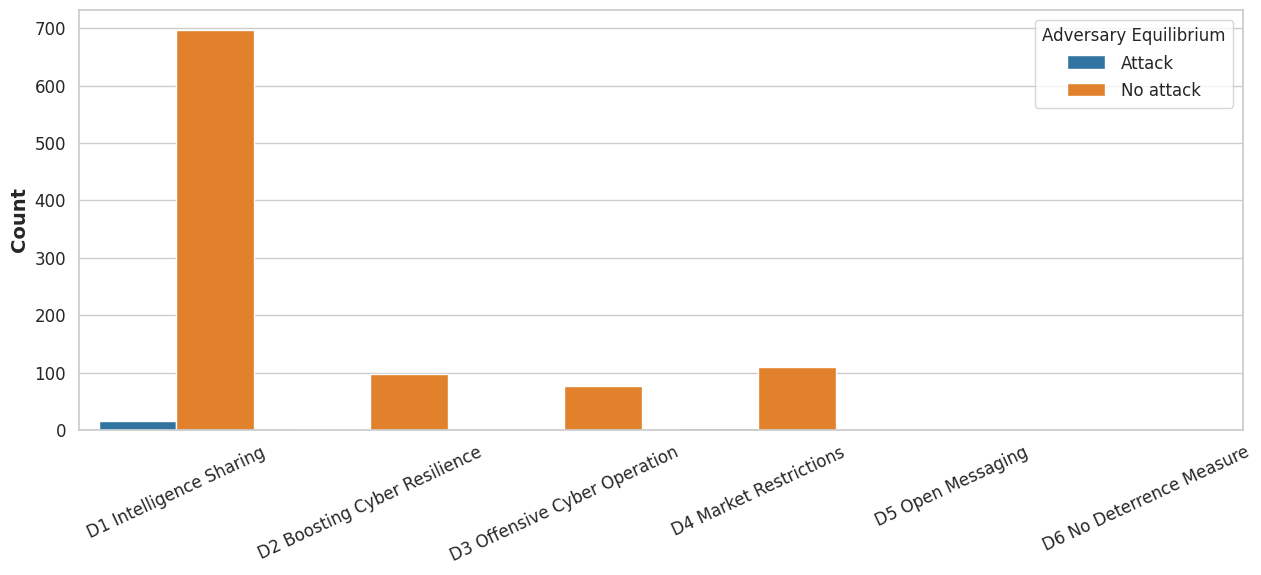

In [ ]:
# Set default plot size before plotting
plt.rcParams['figure.figsize'] = (13, 6)

# Set display settings for line width and font
rc = {'lines.linewidth': 2, 'font.sans-serif': ['DejaVu Sans']}
sns.set_context('notebook', rc=rc, font_scale=1.25)
sns.set_style('whitegrid', rc=rc)

# Define the desired order of the x-axis categories
x_order = ['D1 Intelligence Sharing', 'D2 Boosting Cyber Resilience', 'D3 Offensive Cyber Operation',
           'D4 Market Restrictions', 'D5 Open Messaging', 'D6 No Deterrence Measure']

# Create countplot
ax = sns.countplot(x="Deterrence Equilibrium", hue="Adversary Equilibrium", data=df.iloc[::6, :], hue_order=['Attack', 'No attack'], order=x_order)

# Customize the plot
ax.set_ylabel('Count', fontsize=14, fontweight="bold")
ax.set_xlabel('')

#ax.set_xlabel('Counter-Hybrid Measure', fontsize=16, fontweight="bold")
plt.xticks(fontsize = 12, rotation=25)
plt.yticks(fontsize = 12)

# Customize legend
ax.figure.tight_layout()
plt.setp(ax.get_legend().get_texts(), fontsize='12')  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='12')

# Set plot title
#plt.title('Countplot of the Adversary Actions vs Counter-Hybrid Actions in the Subgame Perfect Equilibriums', fontsize=13, fontweight="bold")

# Capture the figure
fig = plt.gcf()

# Display the plot
plt.show()

In [ ]:
df.iloc[::6, :].groupby('Equilibria').size()

,0
Equilibria,
"('D1 Intelligence Sharing', 'Attack')",15
"('D1 Intelligence Sharing', 'No attack')",697
"('D2 Boosting Cyber Resilience', 'Attack')",1
"('D2 Boosting Cyber Resilience', 'No attack')",98
"('D3 Offensive Cyber Operation', 'No attack')",76
"('D4 Market Restrictions', 'Attack')",3
"('D4 Market Restrictions', 'No attack')",110


In [ ]:
fig.savefig("game_equilibria.png", dpi=300)
from google.colab import files

# Assuming you've already saved the file as 'high_dpi_scatterplot.png'
files.download('game_equilibria.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>